In [42]:
%config Completer.use_jedi = False
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from keras.layers import *
from keras import Model
from keras.models import load_model
%matplotlib inline

In [2]:
emoji_dictionary = {"0": ":heart:",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [3]:
X_train, Y_train = extract_X_Y('./data/train_emoji.csv')
X_test, Y_test = extract_X_Y('./data/test_emoji.csv')

### One-Hot encoding labels

In [4]:
oh_Y_train = one_hot(Y_train.values, 5)
oh_Y_test = one_hot(Y_test.values, 5)

In [5]:
print("X_train Shape:", X_train.shape)
print("Y_train Shape:", oh_Y_train.shape)
print("X_test Shape:", X_test.shape)
print("Y_test Shape:", oh_Y_test.shape)

X_train Shape: (131,)
Y_train Shape: (131, 5)
X_test Shape: (55,)
Y_test Shape: (55, 5)


In [6]:
idx = 50
print(X_train[idx], label_to_emoji(str(Y_train[idx]), emoji_dictionary))
print("Label index %d is one-hot encoded as:" % Y_train[idx], oh_Y_train[idx])

I think I will end up alone 😞
Label index 3 is one-hot encoded as: [0. 0. 0. 1. 0.]


### Implementing Emojifier V-1

![Emojifier V-1](./images/Emojifier-V1.png)

#### Inputs and outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you). 
* The output will be a probability vector of shape (1,5), (there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

### Glove Word Vector

[GloVe](https://nlp.stanford.edu/projects/glove/) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

#### Read GloVe File

In [7]:
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('./GloVe/glove.6B.50d.txt')

Loading Glove Model..
400000 words loaded!


In [8]:
print("Word_to_vector map Shape:", len(word_to_vec_map.get('food')))

Word_to_vector map Shape: 50


In [9]:
word = 'food'
word_idx = words_to_index.get(word)

print("Word '%s' has index %d in GloVe vector." % (word, word_idx))

idx = 250000
word = index_to_words.get(idx)
print("Index %d belong to the word '%s'." % (idx, word))

Word 'food' has index 151204 in GloVe vector.
Index 250000 belong to the word 'morpheus'.


In [10]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


#### Implementing the V1 model

Now that the sentences's average function is created and GloVe word vector is loaded, its time to construct the model. In this case the model uses cross-entropy cost function:

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

And the gradients are computed as:

$$ \frac{d}{dx}Z^{(i)} = a^{(i)} - Y_{oh}^{(i)}$$

$$ \frac{d}{dx}W^{(i)} = \frac{d}{dx}Z{(i)} . avg^{(i)}$$

$$ \frac{d}{dx}b^{(i)} = \frac{d}{dx}Z^{(i)}$$

***Note:*** The $Y_{oh}$ denotes one-hoted $Y$.

In [11]:
class EmojifierV1:
    def __init__(self, word_to_vector_map, lr=0.01, epochs=400, verbose=1):
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose
        self.word_to_vector_map = word_to_vector_map
        self.W = None
        self.b = None
    
    def fit(self, X, Y):
        assert str(type(X)) == "<class 'numpy.ndarray'>"
        costs = []
        m = X.shape[0]                          
        n_y = 5                                 
        n_h = len(word_to_vec_map.get('food'))

        W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
        b = np.zeros((n_y,))
        
        self.W = W
        self.b = b
        
        Y_oh = one_hot(Y, n_y) 

        for t in range(self.epochs):
            for i in range(m):
                avg = sentence_to_avg(X[i], self.word_to_vector_map)

                z = np.matmul(self.W, avg) + self.b
                a = softmax(z)

                cost = -(np.matmul(Y_oh[i], np.log(a)))
                
                costs.append(cost)
                
                dz = a - Y_oh[i]
                dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
                db = dz

                self.W = self.W - self.lr * dW
                self.b = self.b - self.lr * db

            if self.verbose and t % 100 == 0:
                print("Epoch: " + str(t) + " --- cost = " + str(cost))
        return costs
    
    def predict(self, X):
        m = X.shape[0]
        pred = np.zeros((m, 1))

        for j in range(m):
            avg = sentence_to_avg(X[j], self.word_to_vector_map)

            Z = np.dot(self.W, avg) + self.b
            A = softmax(Z)
            pred[j] = np.argmax(A)
        return pred
    
    def evaluate(self, X, Y):
        pred = self.predict(X)
        accuracy = np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))
        return accuracy

In [12]:
if str(type(X_train)) != "<class 'numpy.ndarray'>":
    X_train = X_train.values
    Y_train = Y_train.values
    X_test = X_test.values
    Y_test = Y_test.values

In [13]:
model = EmojifierV1(word_to_vec_map)
cost_list = model.fit(X_train, Y_train)
accuracy = model.evaluate(X_train, Y_train)
print("Accuracy: %.5f" % accuracy)

Epoch: 0 --- cost = 2.0510213311005927
Epoch: 100 --- cost = 0.07373986202200605
Epoch: 200 --- cost = 0.043931843817170226
Epoch: 300 --- cost = 0.034936321508592744
Accuracy: 0.97710


In [14]:
train_acc = model.evaluate(X_train, Y_train)
print("Training set accuracy: %.5f" % train_acc)
test_acc = model.evaluate(X_test, Y_test)
print('Test set accuracy: %.5f' % test_acc)

Training set accuracy: 0.97710
Test set accuracy: 0.87273


### Plot Training Costs

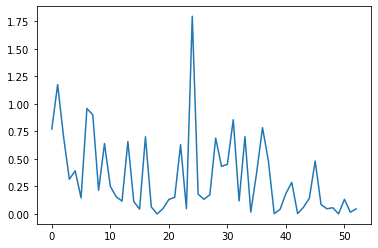

In [15]:
plt.plot(cost_list[::1000])

In [16]:
def print_predictions(sentences, labels, emoji_dictionary):
    for idx, sentence in enumerate(sentences):
        print(sentence, label_to_emoji(str(labels[idx]), emoji_dictionary))

In [17]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array(["0", "0", "2", "1", "4", "3"])

predictions = model.predict(X_my_sentences)
print_predictions(X_my_sentences, Y_my_labels, emoji_dictionary)

i adore you ❤
i love you ❤
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😞


In [18]:
sentence = np.array(["I do not like you"])
prediction = model.predict(sentence)
prediction = list(str(int(prediction[0][0])))
print_predictions(sentence, prediction[0][0], emoji_dictionary)

I do not like you ❤


Amazing! 
* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 

#### Word ordering isn't considered in this model
* Note that the model doesn't get the following sentence correct:
>I do not like you ❤

* And it predicts the lable same as:
>I love you ❤

* This algorithm ignores word ordering, so is not good at understanding phrases like "I do not like you" 

#### Confusion matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

In [19]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

(55,)
            ❤    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    0    0    6    6
All          9    9   18   13    6   55


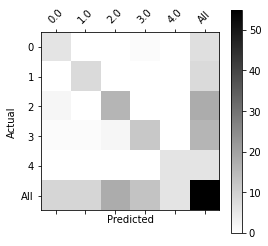

In [20]:
print(Y_test.shape)
pred_test = model.predict(X_test)
print('            ' + label_to_emoji("0", emoji_dictionary)+ '    ' + label_to_emoji("1", emoji_dictionary) + '    ' +  label_to_emoji("2", emoji_dictionary)+ '    ' + label_to_emoji("3", emoji_dictionary)+'   ' + label_to_emoji("4", emoji_dictionary))
print(pd.crosstab(Y_test, pred_test.reshape(55,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

#### V1 Model Conclution
- Even with a 127 training examples, you can get a reasonably good model for Emojifying. 
    - This is due to the generalization power word vectors provides. 
- Emojify-V1 will perform poorly on sentences such as **"This movie is not good and not enjoyable"**
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words.

## Emojifier-V2: Using LSTMs in Keras: 

Let's build an LSTM model that takes word **sequences** as input!
* This model will be able to account for the word ordering. 
* Emojifier-V2 will continue to use pre-trained word embeddings to represent words.
* We will feed word embeddings into an LSTM.
* The LSTM will learn to predict the most appropriate emoji. 

![Emojifier-V2](./images/emojifier-v2.png)

In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0] 
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = [word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        j = 0
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j += 1
    return X_indices

In [22]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, words_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [23]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1 
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
print(np.asarray(embedding_layer.get_weights()).shape)










(1, 400001, 50)


### Emojifier-V2 (Keras)

In [25]:
def Emojify_V2_Keras(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = Bidirectional(LSTM(128))(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=[sentence_indices], outputs=X)
    return model

In [26]:
maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, words_to_index, maxLen)
Y_train_oh = one_hot(Y_train, C = 5)

In [27]:
model = Emojify_V2_Keras((maxLen,), word_to_vec_map, words_to_index)
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________________________

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
131/131 [==============================] - 2s 17ms/step - loss: 1.5733 - acc: 0.2901
Epoch 2/50
131/131 [==============================] - 0s 1ms/step - loss: 1.5109 - acc: 0.3740
Epoch 3/50
131/131 [==============================] - 0s 1ms/step - loss: 1.4458 - acc: 0.4122
Epoch 4/50
131/131 [==============================] - 0s 1ms/step - loss: 1.4122 - acc: 0.4046
Epoch 5/50
131/131 [==============================] - 0s 1ms/step - loss: 1.3256 - acc: 0.4962
Epoch 6/50
131/131 [==============================] - 0s 1ms/step - loss: 1.2082 - acc: 0.5802
Epoch 7/50
131/131 [==============================] - 0s 1ms/step - loss: 1.0545 - acc: 0.6183
Epoch 8/50
131/131 [==============================] - 0s 1ms/step - loss: 0.9511 - acc: 0.6336
Epoch 9/50
131/131 [==============================] - 0s 1ms/step - loss: 0.9854 - acc: 0.6718
Epoch 10/50
131/131 [===========================

#### Mislabeled sentences

In [35]:
y_test_oh = one_hot(Y_test, 5)
X_test_indices = sentences_to_indices(X_test, words_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji: ' + label_to_emoji(str(Y_test[i]), emoji_dictionary) + ' prediction: ' + X_test[i] + label_to_emoji(str(num), emoji_dictionary))

Expected emoji: 😞 prediction: work is hard	😄
Expected emoji: 😞 prediction: This girl is messing with me	❤
Expected emoji: ❤ prediction: I love taking breaks	😞
Expected emoji: 😄 prediction: you brighten my day	❤
Expected emoji: 😞 prediction: she is a bully	❤
Expected emoji: ❤ prediction: I love you to the stars and back	😄


### Test your own sentence!

In [40]:
x_test = np.array(['He is messing with me !'])
X_test_indices = sentences_to_indices(x_test, words_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(str(np.argmax(model.predict(X_test_indices))), emoji_dictionary))

He is messing with me ! 😄


### Save Model

In [44]:
model.save('./model/model.h5')
model.evaluate(X_train_indices, Y_train_oh)

131/131 [==============================] - 1s 4ms/step


[0.04560496577751318, 0.9923664122137404]

In [45]:
model = load_model('./model/model.h5')

In [47]:
model.evaluate(X_train_indices, Y_train_oh)

131/131 [==============================] - 1s 5ms/step


[0.04560496577751318, 0.9923664122137404]